# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem Statement

In this project our main challenge is to identify the user-offer relationship. We have given datasets for user, offers and transaction respectiveyly. The transaction dataset binds the 2 entitites. Using the above 3 datasets we will try to find answers for the following 2 questions:
1. What are the main features responsible for a successful offer ?
2. Given a set of features, can we predict if the offer would be a success ?

Our approach would be:
1. **Data Exploration:** basic exploration of the datasets
2. **Data Preprocessing:** data wrangling & cleaning, to keep the data ready for ML model
3. **Feature Engineering:** extract new features from existing info that are helpful in data modeling step
4. **Data Modeling:** build a supervised learning model. We will use accuracy & MSE as metrics for evaluating the model's efficiency
5. **Conclusion:** conclude the observations

## Import the needed packages ##

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration ##

In [3]:
print(portfolio.shape)
portfolio.head(10)

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [5]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [6]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
offer_id      0
offer_type    0
reward        0
dtype: int64

In [7]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [8]:
portfolio['offer_id'].nunique()

10

Following things are observed regarding the **Portfolio** dataset:
* There are 10 unique offers available
* No data is missing
* Max offers are for **BOGO** & **Discount**
* *id* column is converted to *offer_id* for convenience

In [9]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [11]:
profile.rename(columns={'id': 'user_id'}, inplace=True)

In [12]:
profile['user_id'].nunique()

17000

In [13]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
user_id                0
income              2175
dtype: int64

Since 2175 records do not have **gender** and **income** values, we will find more details about these missing values.

In [14]:
profile[profile.isnull().any(axis=1)]

,age,became_member_on,gender,user_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


All these values are associated with users with **age** = 118, one likely reason could be that it's the default setting of the mobile app for any user who does not give his/her basic info.

Before concluding, let's confirm this observation further.

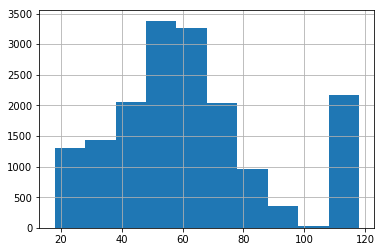

In [15]:
profile['age'].hist()

In [16]:
profile[profile.isnull().any(axis=1)]['age'].value_counts()

118    2175
Name: age, dtype: int64

In [17]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

With above observation we can confirm that all the missing values belong to users with **age** = 118. We will do further processing in the **Data Preprocessing** step.

In [18]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

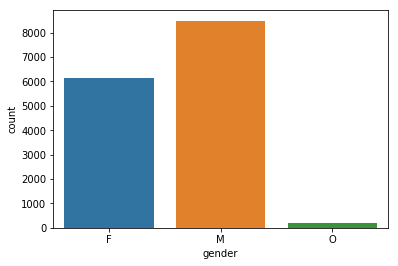

In [19]:
sns.countplot(profile['gender'])

Following things are observed regarding the **Profile** dataset:
* There are totally 17000 unique users in the dataset
* Out of these, 2175 users have *gender* & *income* values missing
* Male users are more than Female and Other
* *id* column is converted to *user_id* for convenience 

In [20]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [22]:
transcript.rename(columns={'person': 'user_id'}, inplace=True)

In [23]:
transcript['user_id'].nunique()

17000

In [83]:
transcript.isna().sum()

event      0
user_id    0
time       0
value      0
dtype: int64

Following things are observed regarding the **Transcript** dataset:
* There are totally 306534 records in the dataset
* All transactions are associated to all the users from the **Profile** dataset
* No record is missing
* *person* column is converted to *user_id* for convenience

## Data Preprocessing ## 

In [24]:
def create_dummies_from_list(df, col, dummy_list):
    '''
    Creates dummy columns for categorical col in df using the dummy_list
    '''
    for dummy_candidate in dummy_list:
        df[col + '_' + dummy_candidate] = df[col].apply(lambda x: 1 if dummy_candidate in x else 0)    

In [25]:
portfolio_clean = portfolio.copy()
profile_clean = profile.copy()
transcript_clean = transcript.copy()

**1. Preprocessing Portfolio**

In [26]:
portfolio_clean.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [27]:
portfolio_clean['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

Since **channels** is a categorical column, we will create the dummy columns out of it. This is required for data modeling step.

In [28]:
dummy_channels = ['web', 'email', 'mobile', 'social']
create_dummies_from_list(portfolio_clean, 'channels', dummy_channels)

In [29]:
portfolio_clean.drop('channels', axis=1, inplace=True)

In [30]:
portfolio_clean['offer_type']

0             bogo
1             bogo
2    informational
3             bogo
4         discount
5         discount
6         discount
7    informational
8             bogo
9         discount
Name: offer_type, dtype: object

Since **offer_type** is a categorical column, we will create the dummy columns out of it. This is required for data modeling step.

In [31]:
dummy_offer_types = ['bogo', 'discount', 'informational']
create_dummies_from_list(portfolio_clean, 'offer_type', dummy_offer_types)

In [32]:
portfolio_clean.drop('offer_type', axis=1, inplace=True)

In [33]:
portfolio_clean.head()

,difficulty,duration,offer_id,reward,channels_web,channels_email,channels_mobile,channels_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


**2. Preprocessing Profile**

In [34]:
profile_clean.head()

,age,became_member_on,gender,user_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Extract **year** & **month** info from **became_member_on** column

In [35]:
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format = '%Y%m%d')

In [36]:
profile_clean['membership_year'] = profile_clean['became_member_on'].dt.year

In [37]:
profile_clean['membership_month'] = profile_clean['became_member_on'].dt.month

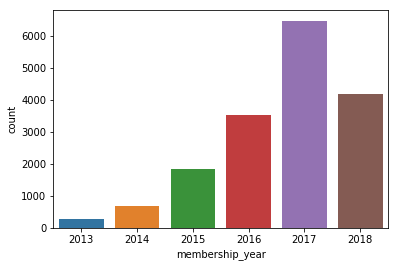

In [38]:
sns.countplot(profile_clean['membership_year'])

From the graph we can conlude that the year 2017 has seen the maximum new users

From the **Data Exploration** step we know that there are 2175 values missing for **gender** & **income** columns.
There could be valid transactions done from these unknown users as well. But to keep our approach simple, we would classifiy these unknown users as outliers and delete the corresponding records related to them.

In [39]:
outlier_user_ids = profile_clean[profile_clean['age'] == 118]['user_id']

In [40]:
outlier_df = profile_clean[profile_clean['user_id'].isin(outlier_user_ids)]

We may use *outlier_df* for further analysis, but to keep our approach simple, I will ignore it for this project.

In [41]:
profile_clean = profile_clean[~profile_clean['user_id'].isin(outlier_user_ids)]

Since **gender** is a categorical column, we will create the dummy columns out of it. This is required for data modeling step.

In [42]:
dummy_genders = ['M', 'F', 'O']
create_dummies_from_list(profile_clean, 'gender', dummy_genders)

In [43]:
profile_clean.drop(['gender', 'became_member_on'], axis=1, inplace=True)

In [44]:
profile_clean.head()

,age,user_id,income,membership_year,membership_month,gender_M,gender_F,gender_O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,0,1,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,1,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,1,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,1,0,0


**3. Preprocessing Transcript**

In [45]:
transcript_clean.head()

,event,user_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Remove the transactions related to outlier/unknown users in **Profile** dataset.

In [46]:
transcript_clean = transcript_clean[~transcript_clean['user_id'].isin(outlier_user_ids)]

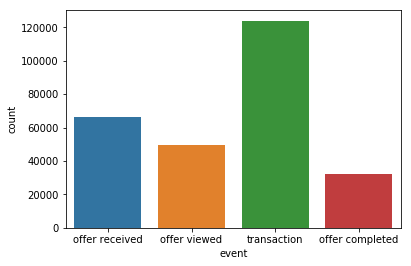

In [47]:
sns.countplot('event', data= transcript_clean)

As clear from the graph, the **transaction** events are the maximum in the dataset

I have tried to follow a simple approach here. I would split the existing **transctipt** dataset into 2 new datasets:
1. **transaction_df:** stores all the transactions events only
2. **offer_df:** stores all other events (offer received, offer viewed & offer completed)

We will use these 2 df's in feature engineering step to create one final **master_df** that would store all the features required for Modeling.

In [48]:
transaction_df = transcript_clean[transcript_clean['event'] == 'transaction']

In [49]:
transaction_df.head()

,event,user_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [50]:
transaction_df['event'].value_counts()

transaction    123957
Name: event, dtype: int64

In [51]:
offer_df = transcript_clean[~(transcript_clean['event'] == 'transaction')]

In [52]:
offer_df.head()

,event,user_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [53]:
offer_df['event'].value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

Since the **offer_id/amount** info is encapsulated in dictionary under **value** column, we will process this column to extract offer_id and amount respectively.

In [54]:
keys_set = set()
for i, row in transcript_clean.iterrows():
    for key in row['value']:
        keys_set.add(key)

In [55]:
keys_set

{'amount', 'offer id', 'offer_id', 'reward'}

In [56]:
for i, row in offer_df.iterrows():
    for key, value in row['value'].items():
        if key == 'offer id' or key == 'offer_id':
            offer_df.at[i, 'offer_id'] = value

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [57]:
offer_df.drop('value', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [58]:
offer_df.head()

,event,user_id,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [59]:
for i, row in transaction_df.iterrows():
    for key, value in row['value'].items():
        if key == 'amount':
            transaction_df.at[i, 'amount'] = value

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [60]:
transaction_df.drop('value', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [61]:
transaction_df.head()

,event,user_id,time,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


For observation purpose, an important metric is that for every offer, how many events have been transacted with the user. To do this:

In [62]:
offer_count_dict = {'offer received': 'offer_received_count', 'offer viewed': 'offer_viewed_count', 
                    'offer completed': 'offer_completed_count'}
offer_count_df = pd.DataFrame(columns=['offer_id'])

for offer in offer_count_dict:
    df_offer = offer_df[offer_df['event'] == offer]
    df_offer_count = df_offer[['offer_id', 'event']].groupby('offer_id').count().reset_index()
    df_offer_count.rename(columns={'event': offer_count_dict[offer]}, inplace=True)
    offer_count_df = pd.merge(offer_count_df, df_offer_count, how='outer')

offer_count_df.head(10)

,offer_id,offer_received_count,offer_viewed_count,offer_completed_count
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,2215,3386.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,6379,4886.0
2,2906b810c7d4411798c6938adc9daaa5,6631,3460,3911.0
3,3f207df678b143eea3cee63160fa8bed,6657,3487,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,6329,3310.0
5,5a8bc65990b245e5a138643cd4eb9837,6643,5873,NaN
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3499,4188.0
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,5901,3657.0
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,6310,4103.0
9,fafdcd668e3743c1bb461111dcafc2a4,6652,6407,5003.0


Another important observation metric is, how many events were sequentially followed. That is, how many offers, who were received, were also viewed and the completed by the user. To do this:

In [63]:
for i, row in offer_count_df.iterrows():
    offer_count_df['received_and_viewd'] = offer_count_df['offer_viewed_count'] / offer_count_df['offer_received_count']
    offer_count_df['viewed_and_completed'] = offer_count_df['offer_completed_count'] / offer_count_df['offer_viewed_count']
    offer_count_df['recieved_and_completed'] = offer_count_df['offer_completed_count'] / offer_count_df['offer_received_count']

offer_count_df.head(10)

,offer_id,offer_received_count,offer_viewed_count,offer_completed_count,received_and_viewd,viewed_and_completed,recieved_and_completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,2215,3386.0,0.329319,1.528668,0.503420
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,6379,4886.0,0.958527,0.765951,0.734185
2,2906b810c7d4411798c6938adc9daaa5,6631,3460,3911.0,0.521792,1.130347,0.589805
3,3f207df678b143eea3cee63160fa8bed,6657,3487,NaN,0.523810,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,6329,3310.0,0.959958,0.522989,0.502048
5,5a8bc65990b245e5a138643cd4eb9837,6643,5873,NaN,0.884089,NaN,NaN
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3499,4188.0,0.523411,1.196913,0.626477
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,5901,3657.0,0.882987,0.619725,0.547209
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,6310,4103.0,0.959550,0.650238,0.623936
9,fafdcd668e3743c1bb461111dcafc2a4,6652,6407,5003.0,0.963169,0.780865,0.752105


From above table, we get variety of observations. <br>
For instance, *offer_id = 0b1e1539f2cc45b7b9fa7c272da2e1d7 (discount)*, the no. of users who completed this offer were more than no. of users have seen this. This means, there are many users (1171) who received a particular offer but did not view them. They completed this offer which signifies they did not get avail this offer. Thus, this represents a case of unsuccssful offer. <br>

Alternatively, *offer_id = 2298d6c36e964ae4a3e7e9706d1fb8c2 (discount)* has followed the expected sequence of successful order which is `offer received -> offer viewed -> transaction -> offer completed`. <br>

For *offer_id = 5a8bc65990b245e5a138643cd4eb9837 (informational)* we don't have offer_completed event associated with it. I could not come up with a strategy for such type of events.

## Feature Engineering
In this step, we will create a master dataframe containing all the features required for data modeling. 

In [64]:
profile_clean.head()

,age,user_id,income,membership_year,membership_month,gender_M,gender_F,gender_O
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,0,1,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,1,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,1,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,1,0,0


In [65]:
portfolio_clean.head(10)

,difficulty,duration,offer_id,reward,channels_web,channels_email,channels_mobile,channels_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [66]:
transaction_df.head()

,event,user_id,time,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [67]:
offer_df.head()

,event,user_id,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


The logic used here is: <br>
An offer is termed successful if its viewed & completed before it's expiry. <br>
`offer_end_time = offer_start_time + offer_duration` <br>
We will extract the transaction amount related to this successful offer as well. 

In [68]:
# This step takes more than 15 minutes to complete. Thus, I have already saved the generated dataframe
# in a csv file (master_data.csv) and loaded in the subsequent step.
def create_master_df(portfolio_clean, profile_clean, offer_df, transaction_df):
    '''
    Creates a single master dataframe by using information from other dataframes
    input:
       - portfolio_clean: preprocessed portfolio dataframe
       - profile_clean: preprocessed profile dataframe
       - offer_df: dataframe containing all events except transactions 
       - transaction_df: dataframe containing transaction events only
    output:
        - list storing rows of master dataframe
    '''
    master_list = []
    
    # iterate every user
    for user_id in profile_clean['user_id']:
        # extract user info
        user = profile_clean[profile_clean['user_id'] == user_id]
        user_offer = offer_df[offer_df['user_id'] == user_id]
        user_transaction = transaction_df[transaction_df['user_id'] == user_id]

        # extract event transacted to/by this user
        offer_received = user_offer[user_offer['event'] == 'offer received']
        offer_viewed = user_offer[user_offer['event'] == 'offer viewed']
        offer_completed = user_offer[user_offer['event'] == 'offer completed']

        master_df_rows = []

        # iterated all the received offers to identify successful offers
        for i in range(offer_received.shape[0]):
            offer_id = offer_received.iloc[i]['offer_id']
            offer = portfolio_clean.loc[portfolio_clean['offer_id'] == offer_id]

            duration_hours = offer['duration'].values[0] * 24
            offer_start_time = offer_received.iloc[i]['time']
            offer_end_time = offer_start_time + duration_hours
            
            # check if offer viewed during its window
            offer_viewed_successfully = np.logical_and(offer_viewed['time'] >= offer_start_time, offer_viewed['time'] <=offer_end_time)

            # check if offer completed during its window
            offer_completed_successfully = np.logical_and(offer_completed['time'] >= offer_start_time, offer_completed['time'] <= offer_end_time)

            offer_successful = offer_viewed_successfully.sum() > 0 and offer_completed_successfully.sum() > 0

            # check transactions associated with the offer
            transaction_successful = np.logical_and(user_transaction['time'] >= offer_start_time, user_transaction['time'] <= offer_end_time) 

            transaction_successful = user_transaction[transaction_successful]

            total_transaction_amount = transaction_successful['amount'].sum()

            # new features required for data modeling
            master_df_row ={'user_id': user_id, 'offer_id': offer_id, 'start_time': offer_start_time,
                           'end_time': offer_end_time, 'total_amount': total_transaction_amount, 
                            'offer_successful': int(offer_successful)} 

            master_df_row.update(offer.iloc[0, 0:].to_dict())
            master_df_row.update(user.iloc[0, :].to_dict())

            master_df_rows.append(master_df_row)

        master_list.extend(master_df_rows)
    
    return master_list

In [69]:
#master_df = pd.DataFrame(create_master_df(portfolio_clean, profile_clean, offer_df, transaction_df))
#master_df.to_csv('master_data.csv')

As stated earlier, to save our time, we will load the **master_df** directly from the persisted csv file.

In [70]:
master_df = pd.read_csv('master_data.csv', index_col=[0])

In [71]:
master_df.head()

,age,channels_email,channels_mobile,channels_social,channels_web,difficulty,duration,end_time,gender_F,gender_M,...,membership_year,offer_id,offer_successful,offer_type_bogo,offer_type_discount,offer_type_informational,reward,start_time,total_amount,user_id
0,55,1,1,0,1,5,7,576,1,0,...,2017,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,408,23.22,0610b486422d4921ae7d2bf64640c50b
1,55,1,1,0,1,0,4,600,1,0,...,2017,3f207df678b143eea3cee63160fa8bed,0,0,0,1,0,504,23.22,0610b486422d4921ae7d2bf64640c50b
2,75,1,1,0,1,5,7,168,1,0,...,2017,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0,5,0,37.67,78afa995795e4d85b5d9ceeca43f5fef
3,75,1,1,1,0,0,3,240,1,0,...,2017,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,0,168,49.39,78afa995795e4d85b5d9ceeca43f5fef
4,75,1,1,1,0,10,7,576,1,0,...,2017,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,0,10,408,48.28,78afa995795e4d85b5d9ceeca43f5fef


In [72]:
master_df.shape

(66501, 23)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


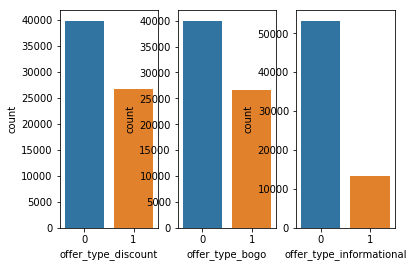

In [73]:
fig, ax =plt.subplots(1,3)
sns.countplot(master_df['offer_type_discount'], ax=ax[0])
sns.countplot(master_df['offer_type_bogo'], ax=ax[1])
sns.countplot(master_df['offer_type_informational'], ax=ax[2])
fig.show()

From the graph, number of **BOGO** and **Discount** offer types have been transacted more than the **Informational** type.

## Data Modeling ##
We will use Accuracy and Mean Squared Error to evaluate our model performance.

In [74]:
def train_and_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - X_train: features in training set
       - y_train: prediction variable in training set
       - X_test: features testing set
       - y_test: prediction variable in testing set
    '''
    
    model = model.fit(X_train, y_train)
    
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    
    training_score = model.score(X_train,y_train)
    testing_score = model.score(X_test,y_test)
     
    print('MSE train : {}'.format(mean_squared_error(y_train, predictions_train)))
    print('MSE test : {}'.format(mean_squared_error(y_test, predictions_test)))
    print('Training accuracy : {}'.format(training_score))
    print('Test accuracy : {}'.format(testing_score))
    print(classification_report(y_test, predictions_test, digits=4))

In [75]:
X = master_df.drop(columns=['offer_id', 'offer_successful', 'user_id'])
y = master_df['offer_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

First we will use a **RandomForestClassifier** with default settings

In [76]:
rfc = RandomForestClassifier(random_state=42)
train_and_predict(rfc, X_train, y_train, X_test, y_test)

MSE train : 0.006355889724310777
MSE test : 0.09208468663539035
Training accuracy : 0.9936441102756892
Test accuracy : 0.9079153133646096
             precision    recall  f1-score   support

          0     0.9090    0.9172    0.9130      8763
          1     0.9067    0.8976    0.9022      7863

avg / total     0.9079    0.9079    0.9079     16626



The high training accuracy could be due to overfitting problem. But we get a decent score for test data in terms of accuracy and f1-score as well. We will improve the **RandomForestClassifier** further using the grid search to see if we get better results.

In [77]:
feature_importances = pd.Series(rfc.feature_importances_, index=X.columns)

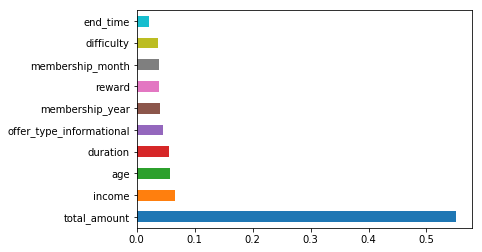

In [78]:
feature_importances.nlargest(10).plot(kind = 'barh')

From the above graph, **amount** feature gets the highest importance for our model followed by **income** and **age**.

In [79]:
param_grid = {
    'n_estimators' : [100, 200],
    'max_depth': [25, 50],
    'min_samples_split': [5, 10]   
}

In [80]:
cv = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid=param_grid)
train_and_predict(cv, X_train, y_train, X_test, y_test)

MSE train : 0.04673684210526316
MSE test : 0.08306267292192951
Training accuracy : 0.9532631578947368
Test accuracy : 0.9169373270780705
             precision    recall  f1-score   support

          0     0.9320    0.9087    0.9202      8763
          1     0.9010    0.9261    0.9134      7863

avg / total     0.9173    0.9169    0.9170     16626



After using **RandomForestClassifier** with **GridSearch**, we see some further improvement in accuracy & f1-score for test data. We will now find the best params for this improved model.

In [85]:
cv.best_params_

{'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 100}

## Conclusion
To identify the offer<->user relationship, we started with basic data exploration to find the columns in the given datasets which need processing. This is followed by data preprocessing step where we created dummy columns for categorical variables, discarded potential outliers and converted data types of column as per the need. <br>

In the feature extraction step, we created a master dataset that contains all the features along with the resultant variable **order_successful** that stores boolean values of 0 or 1. We called an offer successful if the events associated with it (viewed & completed) were executed before its expiry. We also extracted the total_amount associated with the succesful offer. <br>

Since our output feature/variable was a boolean, we solved this classficiation problem using a classifer (RandomForestClassifier). Initally we used it with default setting resulting in test accuracy of 90.79%. After using GridSearch and tweaking some of the default settings, we could improved our model test accuracy upto 91.69%. We also displayed the best parameters for this final model.<br>

After performing all the above steps, we go back to our original 2 questions with the following conclusions:
1. There are some features more important than others. That is, **amount** spent or **income** earned by a user is more significant than other features such as offer_duration.
2. We can predict (with 91.69% accuracy) if an offer with some given set of features would be successful or not.

Overall, the strategy to create master dataset took the maximum time. Since I followed a simple approach, my solution focuses on BOGO & Discount offers. I found it hard to come up with a strategy for Informational offers. I probably also faced model overfitting problem with training data. But due to my limited knowledge & time issues, I am not able to find a reason for this.

## Improvement
Due to time constraints, I could use only a simple approach to solve this problem. This leaves some areas that we can further explore for better results. Some of these areas include:
* Not discarding unknown users as there are around 10% transactions associated with these users
* We used membership year & month. A more suitable feature could also be total no. of day since the user joined
* We can brainstorm more on idea regarding how to successfully term if an Informational offer is successful or not
* Find a better model than RandomForestClassifier. May be AdaBoostClassifier or GradientBoostClassifier perform better here. Or we can explore some Clustering techniques as well.

I really enjoyed working on this project. I wish I had more time but due to my full-time job, I could dedicate only a limited time for this project. But again, the learning will continue as always.